In [1]:
%matplotlib inline
import sys
sys.path.append("..")

In [2]:
import random

import deeptrack as dt

import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf

tracker_input_size = 64


In [3]:
class CrescentMoon(dt.Ellipse):
    def get(self, *inp, radius, offset, **kwargs):
        ellipse = super().get(*inp, radius=radius, **kwargs)
        offset = np.round(offset).astype(np.int)
        other = dt.Affine(translate=offset, mode="constant").resolve(ellipse)
        ellipse[np.array(other > 0)] = 0
        
        return ellipse
        
class Rectangle(dt.Scatterer):
    def get(self, *inp, width, height, **kwargs):
        return np.ones((round(width), round(height), 1))
        

In [4]:

commons = dt.DummyFeature(
    image_size=tracker_input_size,
    position=lambda image_size: image_size / 2 + np.random.randn(2) * 2
)

arguments = dt.Arguments(
    noise_level=lambda: 2 + np.random.rand() * 18,
    key=lambda: np.random.choice(["moon", "rect", "ellipse"]),
)

fluorescence_microscope = dt.Fluorescence(
    NA=0.8,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, tracker_input_size, tracker_input_size)
)

noise = dt.Poisson(snr=arguments.noise_level, background=0.2)

u = dt.units
moon_particle = CrescentMoon(radius=1e-6, offset=(6, 0), position=commons.position)
rectangle_particle = Rectangle(height=18, width=12, position=commons.position)
ellipse_particle = dt.Ellipse(radius=np.array((1, 1)) * u.um, position=commons.position)

particles = {
    "moon": moon_particle,
    "rect": rectangle_particle,
    "ellipse": ellipse_particle
}

particle = dt.OneOfDict(particles, key=arguments.key)

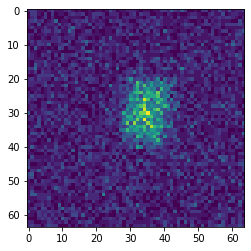

In [22]:


pipeline = (
    fluorescence_microscope(particle)
    >> dt.Affine(rotate=lambda:np.random.rand() * 2 * np.pi)
    >> dt.NormalizeMinMax() 
    + 0.2
) >> noise >> dt.NormalizeMinMax()

pipeline.bind_arguments(arguments)
pipeline.update().plot()

In [6]:
dataset = [pipeline.update().resolve() for _ in range(1000)]
dataset_labels = [np.mean(d.get_property("position", get_one=False), axis=0) for d in dataset]

In [ ]:
def plot(xraw, diff, **kwargs):

    vmin = np.min(xraw)
    vmax = np.max(xraw)
    npoints = 10
    x = np.linspace(vmin, vmax, npoints)

    _x = xraw
    _y = np.abs(diff - np.mean(diff, axis=0))
    
    

    y = np.array([np.mean( _y[(_x >= x[i]) & (_x < x[i+1]) ], axis=0) for i in range(npoints-1)])

    plt.subplot(1, 3, 2)
    plt.plot(x[:npoints-1], y[:npoints-1, 0], **kwargs)
    plt.yscale("log")

    plt.title("Tracking error x")
    plt.ylabel(f"Absolute prediction error")
    plt.xlabel(f"Signal to noise")


    plt.subplot(1, 3, 3)
    plt.plot(x[:npoints-1], y[:npoints-1, 1], **kwargs)
    plt.yscale("log")

    plt.title("Tracking error y")
    plt.ylabel(f"Absolute prediction error")
    plt.xlabel(f"Signal to noise")


In [ ]:
from deeptrack.extras.radialcenter import radialcenter

symmetries = 1
key = "ellipse"
noise_level = 5

model = dt.models.AutoTracker(
    input_shape=(tracker_input_size, tracker_input_size, 1)
)


model_data = dt.Value(pipeline.update().resolve(key=key, noise_level=noise_level))
model.fit(model_data, epochs=20, batch_size=8)

classification = [d.get_property("key") for d in dataset]
classes = set(classification)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(model_data())
plt.axis("off")
plt.title("Model training sample")


colors = ["r", "b", "g"]
for idx, cl in enumerate(classes):

    indexes = np.array(classification) == cl

    dat = np.array(dataset)[indexes]

    predicted_position = model.predict(dat)
    radial_pos = np.array([radialcenter(d) for d in dat])[:, ::-1]



    actual_position = np.array(dataset_labels)[indexes]

    diff = (predicted_position - actual_position)
    diffr = (radial_pos - actual_position)

    xraw = np.array([d.get_property("snr") for d in dataset])[indexes]

    plot(xraw, diff, c=colors[idx])
    plot(xraw, diffr, c=colors[idx], linestyle="--")

legend = []
for x in classes:
    legend.append(f"{x} DeepTrack")
    legend.append(f"{x} Radial Center")

plt.subplot(1, 3, 2)
plt.legend(legend)

plt.subplot(1, 3, 3)
plt.legend(legend)


plt.show()

